# HOMEWORK 1 - Network Measurement and Data Analysis Lab

*Stefano Maxenti, 10526141, 970133*

### Index

[COGENT LOOKING GLASSES](#cogent)

[ATLAS ANCHORS](#atlas)

[CONCLUSIONS](#conclusions)

Let's install and import some packets and library if they are not already available in ouf environment.

In [ ]:
!apt update
!apt install -y iputils-ping traceroute

!pip install scapy
!pip install geopy
!pip install pandas
!pip install matplotlib
!pip install airportsdata
!pip install maxminddb
!pip install ip2location

In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import statistics
import csv
import re
import logging
logging.getLogger("scapy.runtime").setLevel(logging.ERROR)
from scapy.all import *
import re
import json
import urllib
from urllib.request import urlopen
import geopy
from geopy.distance import distance
from geopy import Point
from geopy import Nominatim
import IP2Location, maxminddb
import warnings
import ipaddress
warnings.simplefilter('ignore')

geolocator = Nominatim(user_agent="hw1_project")

In [3]:
# This function sends a ICMP packet to the destination and waits for the answer.
# It returns the mean RTT if there is an answer, None otherwise.
def custom_ping(ip_address):
    RTT = []
    for x in range(10):
        packet = IP(dst = ip_address, version=4) / ICMP(type = 'echo-request',seq=x)
        ans, unans = sr(packet, verbose = False, timeout=0.4)
        if (len(ans)>0 and ans[0].answer.type == 0): #if we receive an answer
            round_trip_time = ans[0][1].time - ans[0][0].sent_time
            RTT.append(round_trip_time*1000) #in ms
            
    if (len(RTT)>0):
            return statistics.mean(RTT)
    else:
        return None

In [4]:
# This is a basic implementation of traceroute using ICMP.
# It returns the IP addresses of the intermediate hops without including the not answering nodes
import socket
def get_list_hops(target_ip):
    list_router = []
    for x in range(64):
      packet = IP(dst = target_ip, ttl = x+1) / ICMP(type = 'echo-request',seq=x)
      ans, unans = sr(packet, verbose = False, timeout = 0.4)
      if(len(ans)>0):
        list_router.append(ans[0][1].src)
        query = ans[0][0]
        answer = ans[0][1]
        rtt = (answer.time - query.sent_time)*1000
        #print(x+1, '\t', answer.src, '\t','%.2f' % rtt, '\t',answer[ICMP].type) #ICMP types: 0 - echo reply, 11 - time exceeded 
        if(ans[0][1].src == target_ip):
          break;
      else:
        continue
    return list_router

In [5]:
# this is the position of the VM used for the test. It is provided by Paperspace and it is located in New York
response = urlopen('http://ipinfo.io/')
data = json.load(response)
response.close()
P1 = Point(data['loc']) 
print(json.dumps(data, indent=2))
print("P1: ", P1)

{
  "ip": "172.83.13.4",
  "city": "Newark",
  "region": "New Jersey",
  "country": "US",
  "loc": "40.7357,-74.1724",
  "org": "AS394996 47-2339071",
  "postal": "07102",
  "timezone": "America/New_York",
  "readme": "https://ipinfo.io/missingauth"
}
P1:  40 44m 8.52s N, 74 10m 20.64s W


## COGENT Looking Glass

<a id='cogent'></a>

The first set of endpoints I want to test is the set of looking glass IPs of Cogent, one of the biggest transit provider in the world.

There is no public database with the IPs, so I get them manually by pinging an endpoint I own from their website (https://www.cogentco.com/lookingglass.php) and retreiving the source IP by using tcpdump.

I put IP, country and city in a csv file, provided as well.

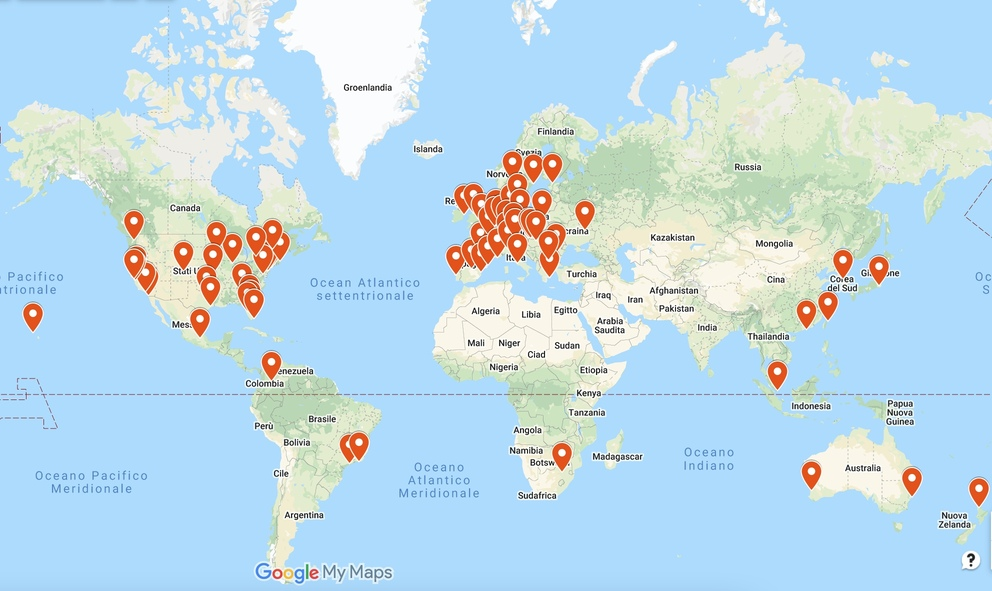

Map can be found here: https://www.google.com/maps/d/edit?mid=1r5Mi9Gh6t2qgW38s2iCS0HmdeIQIn59O&usp=sharing

In [6]:
df = pd.read_csv('cogent.csv')
df['RTT'] = np.nan
df['DIST'] = np.nan
df

,IP,COUNTRY,CITY,RTT,DIST
0,130.117.254.98,AT,Vienna,NaN,NaN
1,206.149.255.6,AU,Perth,NaN,NaN
2,206.149.255.2,AU,Sydney,NaN,NaN
3,130.117.254.18,BE,Brussels,NaN,NaN
4,130.117.254.226,BG,Sofia,NaN,NaN
...,...,...,...,...,...
65,66.250.250.114,US,San Jose,NaN,NaN
66,66.250.250.58,US,Seattle,NaN,NaN
67,66.250.250.162,US,Tampa,NaN,NaN
68,66.250.250.122,US,Washington DC,NaN,NaN


In [7]:
index = 0
for ip in df['IP']:
    target_ip = ip
    location = geolocator.geocode(df.iloc[index]['CITY'])
    dist = distance(P1, (location.latitude, location.longitude)).kilometers
    rtt = custom_ping(target_ip)
    if (rtt is not None):
        df.at[index, 'DIST'] = dist
        df.at[index, 'RTT'] = rtt
    index += 1
df = df.dropna().sort_values(by='DIST')
df

,IP,COUNTRY,CITY,RTT,DIST
59,66.28.3.114,US,New York,1.462960,14.286597
61,66.250.250.106,US,Philadelphia,3.570914,121.036603
48,66.250.250.26,US,Boston,8.627653,316.292832
68,66.250.250.122,US,Washington DC,7.330513,319.198743
7,66.250.250.170,CA,Montreal,9.928083,531.904778
...,...,...,...,...,...
4,130.117.254.226,BG,Sofia,110.734701,13825.677811
38,206.149.255.18,NZ,Auckland,243.228507,14173.674685
43,66.250.250.202,SG,Singapore,247.211719,15338.248290
2,206.149.255.2,AU,Sydney,210.341859,15972.904428


In [435]:
# to save
# df.to_csv("RESULTS/cogent_results.csv", index=False)
# to load the final results
# df = pd.read_csv("RESULTS/cogent_results.csv")

Let's fit a 1D-polynomial function over the set of measurements.

In [436]:
coefficients = np.polyfit((df['DIST']).astype(str).astype(float), (df['RTT']).astype(str).astype(float), 1)
poly = np.poly1d(coefficients)
print(poly)

 
0.01454 x + 5.296


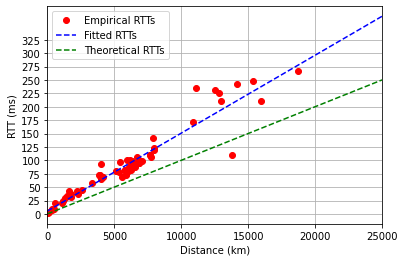

In [437]:
fig = plt.figure();
plt.plot(df['DIST'], df['RTT'], 'o', color='red', label="Empirical RTTs");

xi = np.arange(0, 25000, 1)

plt.xlabel("Distance (km)");
plt.ylabel("RTT (ms)");
plt.xlim([0,25000])
#plt.ylim([0,350])
plt.yticks(np.arange(0, 350, step=25))

plt.plot(xi, poly(xi), '--b', label='Fitted RTTs')
plt.plot(xi, 2*xi/200000*1000, '--g', label='Theoretical RTTs')
plt.legend()
plt.grid(visible=True);

There is a clearly linear trend, although some outliers can be seen. The discrepancy is due the fact that the distance between endpoints is usually greater than the geodetic distance. In real networks, there are many intermediate routers and they make the distance bigger.

Here is an example using an endpoint localized in Auckland, New Zealand.

DIRECT
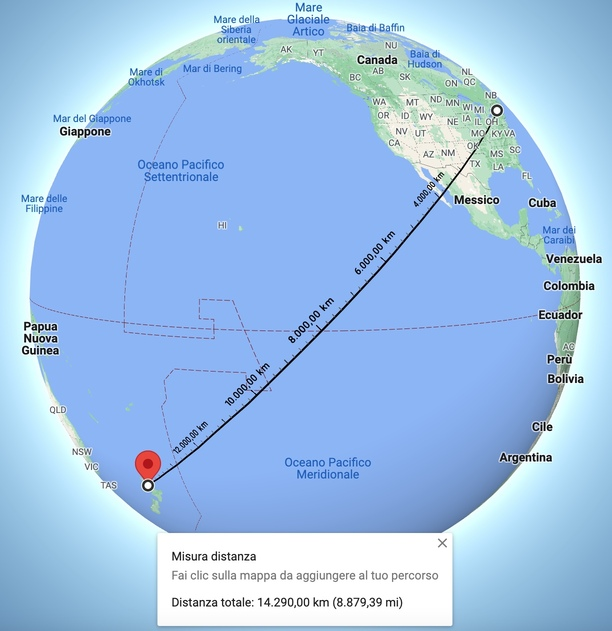

REAL

In [19]:
!traceroute -I 206.149.255.18

traceroute to 206.149.255.18 (206.149.255.18), 30 hops max, 60 byte packets
 1  10-255-228-90.prometheus-kubelet.kube-system.svc.cluster.local (10.255.228.90)  0.118 ms  0.022 ms  0.011 ms
 2  10.255.228.1 (10.255.228.1)  1.194 ms  1.120 ms  1.150 ms
 3  184.105.3.3 (184.105.3.3)  1.637 ms  1.629 ms  1.621 ms
 4  gi0-1-0-8.nr51.b002125-0.ewr03.atlas.cogentco.com (38.142.53.73)  2.013 ms  2.052 ms  2.411 ms
 5  te0-7-0-10.rcr21.ewr03.atlas.cogentco.com (154.24.19.137)  2.750 ms  2.765 ms  2.830 ms
 6  be2262.ccr42.jfk02.atlas.cogentco.com (154.54.47.121)  3.533 ms  2.084 ms  2.046 ms
 7  be2890.ccr22.cle04.atlas.cogentco.com (154.54.82.245)  13.319 ms  13.321 ms  13.218 ms
 8  be2718.ccr42.ord01.atlas.cogentco.com (154.54.7.129)  19.889 ms  19.904 ms  19.931 ms
 9  be2832.ccr22.mci01.atlas.cogentco.com (154.54.44.169)  32.111 ms  32.135 ms  32.316 ms
10  be3036.ccr22.den01.atlas.cogentco.com (154.54.31.89)  43.607 ms  43.798 ms  43.476 ms
11  be3038.ccr32.slc01.atlas.cogentco.com (154.5

We can see that the packets travels following the route:

NEW YORK -> CLEVELAND -> CHICAGO -> KANSAS CITY -> DENVER -> SALT LAKE CITY -> SEATTLE -> PORTLAND -> SYDNEY -> AUCKLAND 

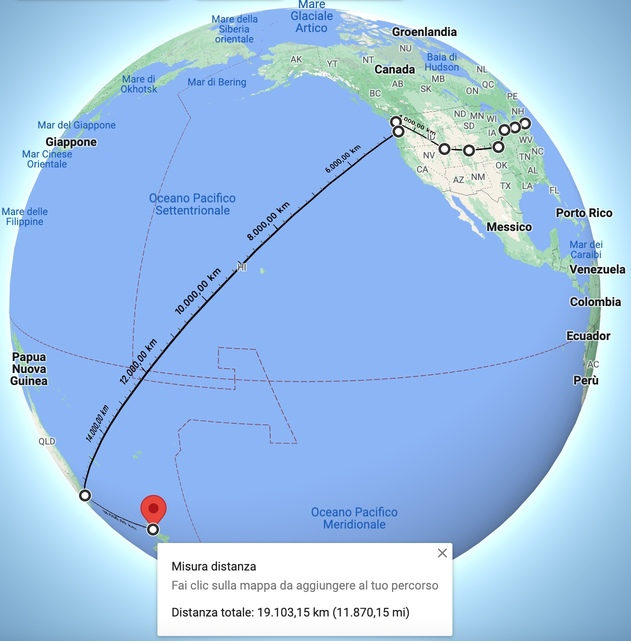

Choosing Cogent as target has a big advantage regarding localization of core routers: their intermediate routers have PTR domains that include their locations as the IATA code of the closest airport. By matching the IATA codes with the coordinates of the airport, it is possible able to provide a more precise geolocalization service. In addition to that, the VM I am using always connects to Cogent after three hops and since the endpoint belongs to Cogent, the testing packet always remains in the Cogent network.

We introduce the following function, that calculates the actual distance by findings all layer 3 hops in the middle and calculating the sum of the partial distances. Notice that it is not possible to consider other layer-2 hops (for example optical switches) as they do not appear in the traceroute.

In [11]:
import airportsdata
airports = airportsdata.load('IATA')

def get_cumulative_distance_traceroute_airport(P1, ip):
    list_closest_airport = []
    d_ = []
    list_router = get_list_hops(ip)
    #print(list_router)
    for ip in list_router[3:]: # I skip the first three hops before peering with Cogent
        domain = socket.gethostbyaddr(ip)[0] # getting the PTR from the IP
        # some string parsing: all addresses are in the form ***.XXXNN.atlas.cogentco.com
        # *** can be ignored, XXX is the three-digit IATA code, NN a number.
        # Starting from the final word (com), I go back the XXXNN part and remove the numbers with a regex
        airport = re.sub(r'\d+', '', domain.split('.')[-4]).upper()
        # Some IATA codes are generic for a location. This is a small correction of the database
        if (airport == 'LON'):
            airport = 'LHR'
        if (airport == 'YMQ'):
            airport = 'YUL'
        if (airport == 'TYO'):
            airport = 'HND'
        if (airport == 'PAR'):
            airport = 'CDG'
        if (airport == 'MIL'):
            airport = 'MXP'
        if (airport == 'STO'):
            airport = 'ARN'
        if (airport == 'ROM'):
            airport = 'FCO'
        if (airport == 'BUH'):
            airport = 'OTP'
        if (airport == 'RIO'):
            airport = 'GIG'
        if (airport == 'SEL'):
            airport = 'ICN'
        list_closest_airport.append(airport)
    #print(ipinfo_list)
    for a in list_closest_airport:
        try:
            P2 = Point(airports[a]['lat'], airports[a]['lon'])
            d = distance(P1, P2).kilometers
            #print(d)
            d_.append(d)
            P1 = P2
        except:
            print(airport + " not in list")
            continue
    return sum(d_)

This are the calculations made by Python itself:

In [12]:
location = geolocator.geocode('AUCKLAND')
print('Geodetic distance: ', distance(P1, (location.latitude, location.longitude)).kilometers)
print('Real distance:     ', get_cumulative_distance_traceroute_airport(P1, '206.149.255.18'))

Geodetic distance:  14173.674684899352
Real distance:      19187.276782513032


In [63]:
# Uncomment this lines if you want to test latency from stratch 
# instead of updating just the distance on the previous dataset
# df = pd.read_csv('cogent.csv')
# df['RTT'] = np.nan
# df['DIST'] = np.nan

In [65]:
index = 0
for ip in df['IP']:
    dist = get_cumulative_distance_traceroute_airport(P1, ip)
    df.at[index, 'DIST'] = dist
    # following lines should be uncommented (and if you want to test latency again.
    # right now I just want to update the DIST field without running the code again.
    #rtt = custom_ping(ip)
    #if (rtt is not None):
        #df.at[index, 'DIST'] = dist
        #df.at[index, 'RTT'] = rtt
    index += 1
df = df.dropna().sort_values(by='DIST')
df

,IP,COUNTRY,CITY,RTT,DIST
0,66.28.3.114,US,New York,1.462960,38.283712
1,66.250.250.106,US,Philadelphia,3.570914,189.093755
2,66.250.250.26,US,Boston,8.627653,338.778606
3,66.250.250.122,US,Washington DC,7.330513,380.896228
4,66.250.250.170,CA,Montreal,9.928083,575.002786
...,...,...,...,...,...
68,206.149.255.2,AU,Sydney,210.341859,17023.074383
61,205.199.1.30,KR,Seoul,234.886980,18670.008564
67,66.250.250.202,SG,Singapore,247.211719,18712.268122
66,206.149.255.18,NZ,Auckland,243.228507,19187.276783


In [438]:
# to save
# df.to_csv("RESULTS/cogent_traceroute_airport.csv", index=False)
# to load the final results
# df = pd.read_csv("RESULTS/cogent_traceroute_airport.csv")

In [442]:
coefficients = np.polyfit((df['DIST']).astype(str).astype(float), (df['RTT']).astype(str).astype(float), 1)
poly = np.poly1d(coefficients)
print(poly)

 
0.01259 x + 7.971


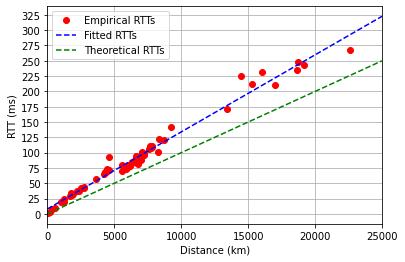

In [443]:
fig = plt.figure();
plt.plot(df['DIST'], df['RTT'], 'o', color='red', label="Empirical RTTs");

xi = np.arange(0, 25000, 1)

plt.xlabel("Distance (km)");
plt.ylabel("RTT (ms)");
plt.xlim([0,25000])
#plt.ylim([0,350])
plt.yticks(np.arange(0, 350, step=25))

plt.plot(xi, poly(xi), '--b', label='Fitted RTTs')
plt.plot(xi, 2*xi/200000*1000, '--g', label='Theoretical RTTs')
plt.legend()
plt.grid(visible=True);

It is now possible to see that the outliers of before are now much closer to the fitted line.
This proves the point that real network distances in long-haul networks are definitely higher than the distance as the crow flies.

## Anchors for RIPE Atlas networks

<a id='atlas'></a>

In order to get a better variety of IP to test, I decide to use anchors from the RIPE Atlas network.

Atlas is a measurement project made by RIPE born to provide to researchers a flexible way to test latency, reachability and other performance figures using both hardware and software probes.

Everyone can apply for a probe and host it in their own network. More specialized probes, called anchors, are requested and managed directly by ISP and ASN owners. Anchors are usually located inside central offices and Internet Exchange Points.

I don't use the specific APIs of Atlas, but I retrieve the ip addresses of their anchors as endpoint for my tests.
I don't use all probes because they would be too many and their measurements may be affected by more uncertainties than the anchors' (for example, user probes may be connected over 4G networks or on old and ruined copper lines).

The list can be downloaded from here: https://ftp.ripe.net/ripe/atlas/probes/archive/

I use the database archived on February 24th 2022.

In addition to the IP addresses of the anchors, there are geographical information, including latitude and longitude.

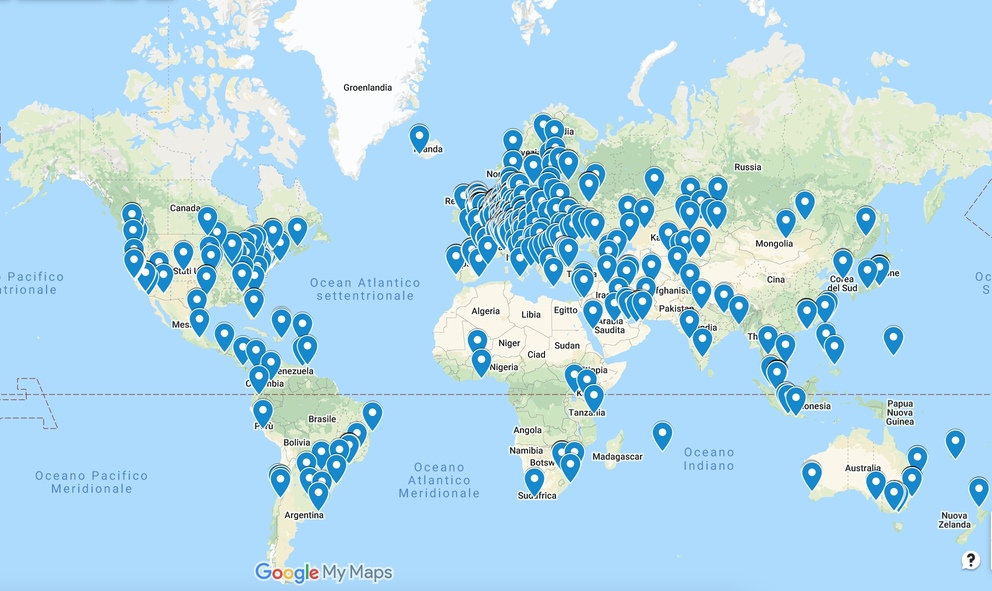

Map can be found here: https://www.google.com/maps/d/edit?mid=1vGntomwo8dU-Ro7oO2fKSVyGcAqSIDRF&usp=sharing

This is the output of the anchor sponsored by MIX-IT and installed in the homonymous Internet Exchange Point.

In [18]:
url = 'https://atlas.ripe.net/api/v2/probes/6094/'
response = urlopen(url)
data = json.load(response)
response.close()
print(json.dumps(data, indent=2))

{
  "address_v4": "217.29.76.27",
  "address_v6": "2001:1ac0:0:200:0:a5d1:6004:27",
  "asn_v4": 16004,
  "asn_v6": 16004,
  "country_code": "IT",
  "description": "MIX",
  "first_connected": 1417086355,
  "geometry": {
    "type": "Point",
    "coordinates": [
      9.1015,
      45.4795
    ]
  },
  "id": 6094,
  "is_anchor": true,
  "is_public": true,
  "last_connected": 1646502185,
  "prefix_v4": "217.29.72.0/21",
  "prefix_v6": "2001:1ac0::/32",
  "status": {
    "id": 1,
    "name": "Connected",
    "since": "2022-03-03T11:31:12Z"
  },
  "status_since": 1646307072,
  "tags": [
    {
      "name": "system: Resolves AAAA Correctly",
      "slug": "system-resolves-aaaa-correctly"
    },
    {
      "name": "system: Resolves A Correctly",
      "slug": "system-resolves-a-correctly"
    },
    {
      "name": "system: Anchor",
      "slug": "system-anchor"
    },
    {
      "name": "system: IPv4 Stable 90d",
      "slug": "system-ipv4-stable-90d"
    },
    {
      "name": "system: IP

Let's import the database.

In [19]:
f = open('atlas.json','r')
atlas_json = json.load(f)
# some basic parsing
atlas_json = atlas_json['objects']

In [20]:
dicts = []
for i in atlas_json:
    # I add only anchors which are actually connected
    if (i['is_anchor'] and i['status_name'] == 'Connected' and i['address_v4'] is not None):
        ip = i['address_v4']
        lat = i['latitude']
        lon = i['longitude']
        cc = i['country_code']
        dicts.append([ip, cc, lat, lon, distance(P1, Point(lat, lon)).kilometers])

Let's create a Pandas dataframe from the dictionary.

In [21]:
df = pd.DataFrame.from_dict(dicts)
df.columns=['IP','COUNTRY','LAT', 'LON','DIST']
# I use NaN to initialize cell values.
df['RTT']=np.nan
df

,IP,COUNTRY,LAT,LON,DIST,RTT
0,213.225.160.239,FR,48.5795,7.7485,6239.014847,NaN
1,145.220.0.55,NL,52.3675,4.8985,5887.668434,NaN
2,5.28.0.17,HU,47.5015,19.0385,7034.978614,NaN
3,213.190.96.41,IS,64.1375,-21.9605,4216.780480,NaN
4,193.171.255.2,AT,48.2085,16.3695,6823.360344,NaN
...,...,...,...,...,...,...
745,31.172.2.34,DE,51.5215,7.3705,6080.534249,NaN
746,155.254.2.42,CA,43.4775,-80.5495,608.814454,NaN
747,80.93.87.194,FR,49.2275,4.0305,5960.647808,NaN
748,45.142.246.158,RU,59.8885,30.3305,6914.431166,NaN


In [22]:
index = 0
for ip in df['IP']:
    target_ip = ip
    rtt = custom_ping(target_ip)
    if (rtt is not None):
        df.at[index, 'RTT'] = rtt
    index += 1
df = df.dropna().sort_values(by='DIST')
df

,IP,COUNTRY,LAT,LON,DIST,RTT
358,92.38.169.178,US,40.7795,-74.0805,9.158603,1.940131
609,170.39.226.151,US,40.7905,-74.0815,9.795005,1.348424
431,23.157.160.140,US,40.7395,-74.0115,13.597444,2.712536
741,217.243.179.165,US,40.7195,-74.0095,13.878976,13.408136
276,152.195.68.35,US,40.7115,-74.0105,13.939724,2.468109
...,...,...,...,...,...,...
653,156.154.96.254,AU,-37.8205,144.9205,16662.163786,215.518475
598,45.121.209.221,AU,-37.8195,144.9175,16662.381181,204.855299
595,116.90.72.210,AU,-34.9315,138.5875,17086.390595,213.787389
597,45.121.208.237,AU,-31.9605,115.7975,18692.919666,241.049099


In [444]:
# to save
# df.to_csv("RESULTS/atlas_anchors_results.csv", index=False)
# to load the final results
# df = pd.read_csv("RESULTS/atlas_anchors_results.csv")

In [445]:
coefficients = np.polyfit((df['DIST']).astype(str).astype(float), (df['RTT']).astype(str).astype(float), 1)
poly = np.poly1d(coefficients)
print(poly)

 
0.01595 x - 1.698


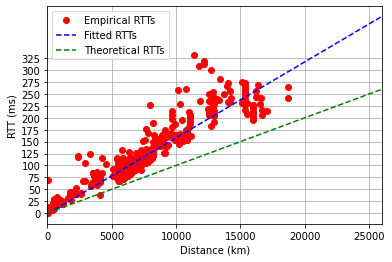

In [448]:
fig = plt.figure();
plt.plot(df['DIST'], df['RTT'], 'o', color='red', label="Empirical RTTs");

xi = np.arange(0, 26000, 1)

plt.xlabel("Distance (km)");
plt.ylabel("RTT (ms)");
plt.xlim([0,26000])
#plt.ylim([0,350])
plt.yticks(np.arange(0, 350, step=25))

plt.plot(xi, poly(xi), '--b', label='Fitted RTTs')
plt.plot(xi, 2*xi/200000*1000, '--g', label='Theoretical RTTs')
plt.legend()
plt.grid(visible=True);

Even though we have many outliers in the distribution, a linear relationship between distance and RTT is visible.

As in the previous scenario, the actual length between endpoints is always more than the direct geodetic link.

For example, using the new dataset, it is possible to compare the different distances between New York City and Patan, Nepal.

DIRECT
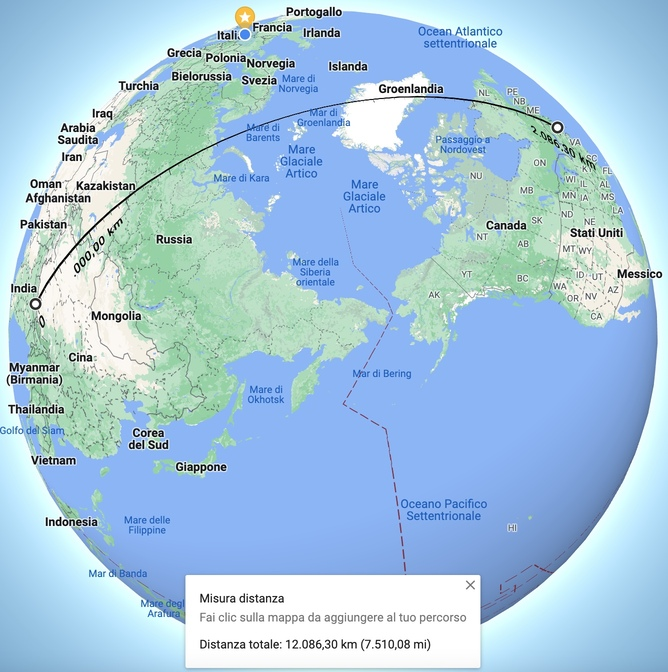

REAL

In [64]:
!traceroute -I 202.52.0.25

traceroute to 202.52.0.25 (202.52.0.25), 30 hops max, 60 byte packets
 1  10-255-228-113.gradient-processing-prometheus-node-exporter.default.svc.cluster.local (10.255.228.113)  0.119 ms  0.033 ms  0.010 ms
 2  10.255.228.1 (10.255.228.1)  0.289 ms  0.280 ms  0.311 ms
 3  184.105.3.3 (184.105.3.3)  2.179 ms  2.190 ms  2.333 ms
 4  208.185.154.97 (208.185.154.97)  4.436 ms  4.439 ms  4.459 ms
 5  ae8.mcs2.lga5.us.zip.zayo.com (64.125.20.105)  9.161 ms  9.134 ms  9.119 ms
 6  * * *
 7  * * *
 8  * * *
 9  ae11.mpr2.slc2.us.zip.zayo.com (64.125.26.43)  48.654 ms  48.791 ms  48.773 ms
10  ae4.mpr1.slc2.us.zip.zayo.com (64.125.26.164)  48.197 ms  48.591 ms  48.664 ms
11  * * *
12  * * *
13  64.125.35.202.IPYX-145641-004-ZYO.zip.zayo.com (64.125.35.202)  63.349 ms  61.782 ms  62.435 ms
14  203.208.171.117 (203.208.171.117)  62.977 ms  62.280 ms  62.385 ms
15  203.208.173.73 (203.208.173.73)  244.719 ms  244.732 ms  244.778 ms
16  203.208.182.253 (203.208.182.253)  252.715 ms  253.952 ms  253

We can see that the packets travels following the route:

NEW YORK -> SALT LAKE CITY -> SAN JOSE -> SINGAPORE -> PATNA -> PATAN
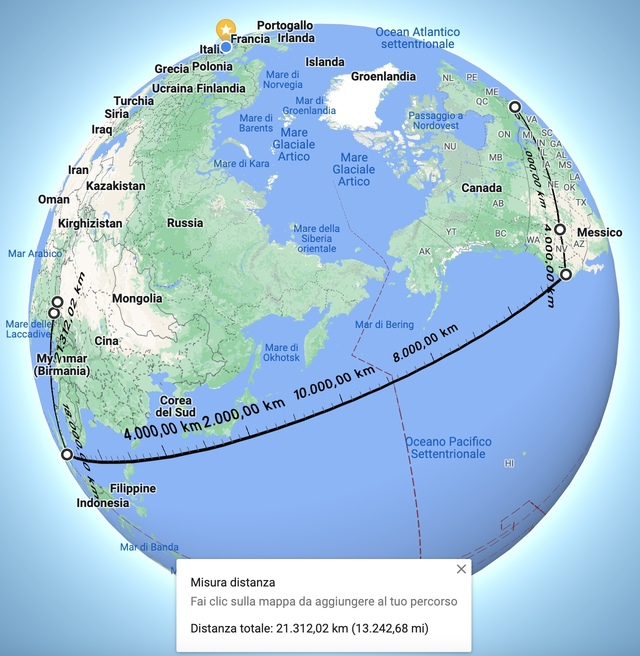

Many free databases are available online, but they lack in precision. It is not easy to figure out which one is better than the other. I use the following databases:
- IP2Location Lite (https://lite.ip2location.com/database/db5-ip-country-region-city-latitude-longitude - registration is needed)
- DB-IP Lite (https://db-ip.com/db/download/ip-to-city-lite - acceptance of the license is needed)
- IPINFO.io (https://ipinfo.io - registering provides a free API which allows up to 50k queries in a month)

I decide to employ a majority voting choice using three free databases, by selecting the corrispondence IP-city that appears in at least two of them; if all of them give different answers, I pick ipinfo.io because in my experiment seemed to be more reliable when the others disagree.

In [168]:
ip2location = IP2Location.IP2Location('IP2LOCATION-LITE-DB5.BIN')
dbip = maxminddb.open_database('dbip-city-lite-2022-02.mmdb')
def ipinfo(ip_address):
    token = '?token=' # token like this: ?token=xxxxxxxxxxxxxx where x...x is the API key
    response = urlopen('http://ipinfo.io/'+ip_address+'/json'+token)
    data = json.load(response)
    response.close() # we are good people, we close the http connection after we finish
    return data

In [169]:
def return_location(ip_address): # majority voting
    # I start by asking the local databases
    ip2location_answer = ip2location.get_all(ip_address)
    dbip_answer = dbip.get(ip_address)
    if (ip2location_answer.city in dbip_answer['city']['names']['en']):
        return ip2location_answer.latitude, ip2location_answer.longitude
    else:
        ipinfo_answer = ipinfo(ip_address)
        if(ipinfo_answer['city'] == ip2location_answer.city):
            return ip2location_answer.latitude, ip2location_answer.longitude
        elif (ipinfo_answer['city'] in dbip_answer['city']['names']['en']):
            return dbip_answer['location']['latitude'], dbip_answer['location']['longitude']
        else: # ipinfo.io seems the best in case of disagreement
            return Point(ipinfo_answer['loc']).latitude, Point(ipinfo_answer['loc']).longitude
            #return ip2location_answer.latitude, ip2location_answer.longitude
            #return dbip_answer['location']['latitude'], dbip_answer['location']['longitude']
    

In [292]:
def get_cumulative_distance_traceroute(P1, target_ip):
    locations = []
    d_ = []
    list_router = get_list_hops(target_ip)
    # no need to check the location of a RFC-1918 or a RFC-6598
    for ip in list_router:
        if (not ipaddress.ip_address(ip).is_private and not ipaddress.ip_address(ip) in ipaddress.ip_network('100.64.0.0/10')):
            loc = return_location(ip)
            locations.append(loc)
    #print(locations)
    for pair in locations:
        P2 = Point(pair)
        d = distance(P1, P2).kilometers
        #print(d)
        d_.append(d)
        P1 = P2
    return sum(d_)

About the Nepal probe, here the Python calculation using the new functions:

In [102]:
location = geolocator.geocode('PATAN')
print('Geodetic distance: ', distance(P1, (location.latitude, location.longitude)).kilometers)
print('Real distance:     ', get_cumulative_distance_traceroute(P1, '202.52.0.25'))

Geodetic distance:  12041.80402816536
Real distance:      21956.199787029476


Going back to the Atlas database, I calculate the distance only of IPs whose RTT is at least 50ms more than the expected RTTs. I don't do the calculations on all IPs because it would take an enormous amount of time and because of the incertanties of the free databases, I might end with much wronger values (for example in case of IPs in border gateways that sometimes are localized in one edge or in the other)

In [310]:
slice_df = df.loc[df['RTT']-poly(df['DIST']) >= 50]
slice = slice_df.index.to_list()
print(len(slice))
slice_df

22


,IP,COUNTRY,LAT,LON,DIST,RTT
5,109.230.208.226,US,40.7185,-74.0085,13.977592,69.289589
83,45.65.244.254,DO,19.7695,-70.5095,2350.350976,118.905640
84,138.255.248.5,DO,19.3905,-70.5205,2391.777860,118.728900
89,200.94.182.170,MX,25.7715,-100.1885,2919.608449,105.048895
90,168.234.77.108,GT,14.6585,-90.5425,3297.334440,124.051942
546,197.239.73.59,BF,12.3715,-1.5085,7665.765603,177.263880
566,178.218.68.22,UA,47.7815,35.1905,7990.746505,227.711678
575,200.132.1.32,BR,-30.0685,-51.1205,8191.493329,189.261007
608,92.38.129.121,RU,48.5005,135.0975,9709.306403,206.827927
610,185.209.84.141,RU,48.4705,135.0585,9713.472898,215.073490


In [311]:
#i = 0
for index in slice:
    db_item = df.iloc[index]
    target_ip = db_item['IP']
    dist = get_cumulative_distance_traceroute(P1, target_ip)
    df.at[index, 'DIST'] = dist
    #i += 1
    #print(i, end = ' ')
df = df.dropna().sort_values(by='DIST')
df

,IP,COUNTRY,LAT,LON,DIST,RTT
0,92.38.169.178,US,40.7795,-74.0805,9.158603,1.940131
1,170.39.226.151,US,40.7905,-74.0815,9.795005,1.348424
2,23.157.160.140,US,40.7395,-74.0115,13.597444,2.712536
3,217.243.179.165,US,40.7195,-74.0095,13.878976,13.408136
4,152.195.68.35,US,40.7115,-74.0105,13.939724,2.468109
...,...,...,...,...,...,...
688,159.65.150.114,IN,12.9715,77.5905,19182.376405,282.315373
659,202.52.0.25,NP,27.7095,85.3205,21960.110769,318.962717
675,188.172.217.86,ZA,-26.1385,28.2005,23026.812151,254.403281
692,27.111.84.21,PH,10.3205,123.9115,24066.818231,273.441720


In [2]:
# to save
# df.to_csv("RESULTS/atlas_anchors_results_traceroute.csv", index=False)
# to load the final results
# df = pd.read_csv("RESULTS/atlas_anchors_results_traceroute.csv")

In [3]:
coefficients = np.polyfit((df['DIST']).astype(str).astype(float), (df['RTT']).astype(str).astype(float), 1)
poly = np.poly1d(coefficients)
print(poly)

 
0.01497 x + 2.312


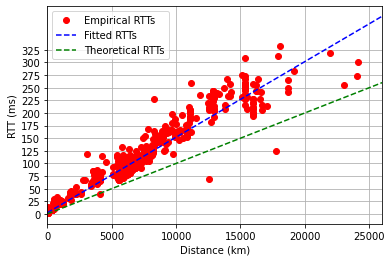

In [451]:
fig = plt.figure();
plt.plot(df['DIST'], df['RTT'], 'o', color='red', label="Empirical RTTs");

xi = np.arange(0, 26000, 1)

plt.xlabel("Distance (km)");
plt.ylabel("RTT (ms)");
plt.xlim([0,26000])
#plt.ylim([0,350])
plt.yticks(np.arange(0, 350, step=25))

plt.plot(xi, poly(xi), '--b', label='Fitted RTTs')
plt.plot(xi, 2*xi/200000*1000, '--g', label='Theoretical RTTs')
plt.legend()
plt.grid(visible=True);

Points are more aligned in a linear pattern and outliers are closer to the fitted line. Unfortunately, some distances are still wrong; points below the green line are definitely erros, since it is not possible to have a smaller RTT than the green value.

Let's remove them.

In [9]:
# to save
# df.to_csv("RESULTS/atlas_anchors_results_traceroute_fixed.csv", index=False)
# to load the final results
# df = pd.read_csv("RESULTS/atlas_anchors_results_traceroute_fixed.csv")

In [5]:
poly_th = np.poly1d([2/200000*1000, 0])
slice_df = df.loc[df['RTT'] <= poly_th(df['DIST'])]
slice = slice_df.index.to_list()
print(len(slice))
slice_df

3


,IP,COUNTRY,LAT,LON,DIST,RTT
133,74.119.118.17,US,37.3985,-122.0085,4105.277769,38.816071
654,109.230.208.226,US,40.7185,-74.0085,12556.938407,69.289589
730,168.234.77.108,GT,14.6585,-90.5425,17783.066042,124.051942


In [6]:
# Removing the slice
df = pd.concat([df, slice_df, slice_df]).drop_duplicates(keep=False)
df

,IP,COUNTRY,LAT,LON,DIST,RTT
0,92.38.169.178,US,40.7795,-74.0805,9.158603,1.940131
1,170.39.226.151,US,40.7905,-74.0815,9.795005,1.348424
2,23.157.160.140,US,40.7395,-74.0115,13.597444,2.712536
3,217.243.179.165,US,40.7195,-74.0095,13.878976,13.408136
4,152.195.68.35,US,40.7115,-74.0105,13.939724,2.468109
...,...,...,...,...,...,...
736,159.65.150.114,IN,12.9715,77.5905,19182.376405,282.315373
737,202.52.0.25,NP,27.7095,85.3205,21960.110769,318.962717
738,188.172.217.86,ZA,-26.1385,28.2005,23026.812151,254.403281
739,27.111.84.21,PH,10.3205,123.9115,24066.818231,273.441720


In [7]:
coefficients = np.polyfit((df['DIST']).astype(str).astype(float), (df['RTT']).astype(str).astype(float), 1)
poly = np.poly1d(coefficients)
print(poly)

 
0.01516 x + 1.385


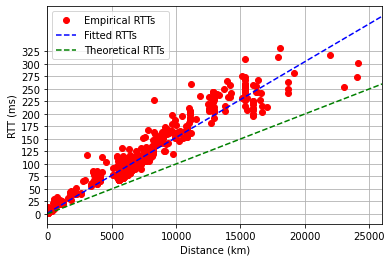

In [8]:
fig = plt.figure();
plt.plot(df['DIST'], df['RTT'], 'o', color='red', label="Empirical RTTs");

xi = np.arange(0, 26000, 1)

plt.xlabel("Distance (km)");
plt.ylabel("RTT (ms)");
plt.xlim([0,26000])
#plt.ylim([0,350])
plt.yticks(np.arange(0, 350, step=25))

plt.plot(xi, poly(xi), '--b', label='Fitted RTTs')
plt.plot(xi, 2*xi/200000*1000, '--g', label='Theoretical RTTs')
plt.legend()
plt.grid(visible=True);

Points are closely aligned in a linear pattern. Points with RTTs much higher than the fitted line are probably badly interconnected with sub-optimal routing, whereas points below the blue line are probably better connected with optimized routing.

## Conclusions

<a id='conclusions'></a>

It appears that a good RTT approximation is a linear function of the distance between the two endpoints.

However, the basic formulation, RTT = 2*(L/C + d/v) + n ≈ 2d/v, where v is the speed of light in an optical fiber (200.000 km/s) is not adequate, in these experiments, to describe the relationship between distance and RTT.
It proves well as a lower bound, because it represents the ideal case of a single optical fiber connecting directly two endpoints.

In real life, the presence of devices (routers, switches, regenerators), with their need of processing data and performing synchronization, affects the round-trip time of a packet. It is also important to consider queues, congestion and saturation in links. In addition to that, ICMP packets may as well have lower priority than other kinds of traffic. In this experiments this may not be a real problem, because the endpoins used in this tests are looking glasses and devices whose function is to measure network performances.

It is possibile to conclude that the overall speed of a packet is definitely smaller than the speed of light in optical fibre.

Considering the coefficients and ignoring the noise term, we can find v (the actual equivalent speed in km/s) by inverting the formula.

Finally, we can calculate the RTT per km. In optical fiber, considering v = 200.000 km/s, the RTT would be 0.01 ms per kilometer, or 1 ms per 100 km.

In [2]:
coeff = [0.01259, 0.01516]
speed = []
for c in coeff:
    s = 2/c*1000
    speed.append(s)
    print("For coefficient ", c, ": speed is ", '%.2f' % s, "km/s")
    print("RTT (ms) per 100 km: ", '%.5f' % (2*1000/s), 
          "ms/km, or equivalently: " '%.2f' % (2*1000/s*100), "ms every 100 km")
    
print("\n")
print("Average between the two datasets: ", '%.2f' % statistics.mean(speed), "km/s")
print("Average RTT (ms) per 100 km: ", '%.5f' % statistics.mean(2*1000/s for s in speed), 
      "ms/km, or equivalently: " '%.2f' % statistics.mean(2*1000/s*100 for s in speed), "ms every 100 km")

For coefficient  0.01259 : speed is  158856.24 km/s
RTT (ms) per 100 km:  0.01259 ms/km, or equivalently: 1.26 ms every 100 km
For coefficient  0.01516 : speed is  131926.12 km/s
RTT (ms) per 100 km:  0.01516 ms/km, or equivalently: 1.52 ms every 100 km


Average between the two datasets:  145391.18 km/s
Average RTT (ms) per 100 km:  0.01388 ms/km, or equivalently: 1.39 ms every 100 km


In retrospective, the most precise measurements came from the Cogent dataset.

This comes from the fortunate choice of the endpoints. 
Packets never leave the Cogent network, so there are no additional delays in exchange with other transits; its RTT per km stays closer to the physical lower bound, whereas there is much more oscillation in the much bigger Atlas dataset since we do not have any info about the hops between the endpoints.

<sup><b> Legal acknowledgments</b></sup>

<sub>This site or product includes IP2Location LITE data available from <a href="https://lite.ip2location.com">https://lite.ip2location.com</a>.</sub>

<sub><a href='https://db-ip.com'>IP Geolocation by DB-IP</a></sub>

<sub><a href='https://ipinfo.io'>IPinfo.io</a></sub>